<h1><center> Un Modelo Predictivo para Identificar Fraudes en Aperturas de Cuentas Bancarias </center></h1>

# Carga de Librerías Clásicas y Dataset

In [1]:
%%HTML
<style>
    body {
        --vscode-font-family: "Cascadia Code PL"
    }
</style>

# Esta celda cambia la fuente del notebook. En caso de no estar la fuente señalada, omitir esta celda pues coloca una fuente serifa de baja legibilidad.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy.stats as stats
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from fx_graficos_fraude import fx_grafico_barra_simple, fx_grafico_barra_subplots, fx_grafico_boxplot
from fx_modelos import fx_train_test_split, fx_modelos_con_sin_balanceo_clases, fx_metricas

import warnings
warnings.filterwarnings('ignore')
sns.set() # para fijar gráficos con estilo seaborn
sns.set_palette('Set2') # para fijar paleta de colores de los gráficos

In [2]:
# Exploración inicial del dataframe
df = pd.read_csv('./Base.csv')
print(f'El dataframe cuenta con {df.shape[0]} registros y {df.shape[1]} columnas')
df.head()

El dataframe cuenta con 1000000 registros y 32 columnas


,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,1,0.9,0.166828,-1,88,50,0.020925,-1.331345,AA,769,...,0,500.0,0,INTERNET,3.888115,windows,0,1,0,7
1,1,0.9,0.296286,-1,144,50,0.005418,-0.816224,AB,366,...,0,1500.0,0,INTERNET,31.798819,windows,0,1,0,7
2,1,0.9,0.044985,-1,132,40,3.108549,-0.755728,AC,870,...,0,200.0,0,INTERNET,4.728705,other,0,1,0,7
3,1,0.9,0.159511,-1,22,50,0.019079,-1.205124,AB,810,...,1,200.0,0,INTERNET,2.047904,linux,0,1,0,7
4,1,0.9,0.596414,-1,218,50,0.004441,-0.773276,AB,890,...,0,1500.0,0,INTERNET,3.775225,macintosh,1,1,0,7


# 1. Análisis Exploratorio de Datos (Exploratory Data Analysis (EDA))

### 1.1. Arreglos Previos para el EDA

Antes de avanzar con el EDA, hay algunas consideraciones que se deben enfrentar antes de proceder. En particular, respecto a los valores nulos y transformación de algunos datos para simplificar su visualización en los gráficos.

#### 1.1.1. Valores Nulos

Algunas variables presentan valores -1 que en realidad corresponden valores NaN, esto aplica a las siguientes columnas:   
* session_length_in_minutes
* device_distinct_emails_8w
* current_address_months_count
* bank_months_count
* prev_address_months_count

Por otra parte, en la variable intended_balcon_amount todos los valores negativos corresponden a valores perdidos.

In [3]:
# se reemplazan los valores -1 por nan en aquellas variables que asi están definidas
lista_variables_a_aplicar_nan = ['session_length_in_minutes', 'device_distinct_emails_8w', 'current_address_months_count', 'bank_months_count', 'prev_address_months_count']

df = df.replace({variable: {-1: np.nan} for variable in lista_variables_a_aplicar_nan})

# se reemplazan los valores negativos por nan
df['intended_balcon_amount'] = np.where(df['intended_balcon_amount']<0, np.nan, df['intended_balcon_amount'])

In [4]:
print('Cantidad de nulos en cantidad\n')
print(df.isna().sum()[df.isna().sum()>0].sort_values(ascending=False))
print('-----------------------------------')
print('Cantidad de nulos en porcentaje\n')
print(round(df.isna().sum()[df.isna().sum()>0]/df.shape[0]*100, 2).sort_values(ascending=False))

Cantidad de nulos en cantidad

intended_balcon_amount          742523
prev_address_months_count       712920
bank_months_count               253635
current_address_months_count      4254
session_length_in_minutes         2015
device_distinct_emails_8w          359
dtype: int64
-----------------------------------
Cantidad de nulos en porcentaje

intended_balcon_amount          74.25
prev_address_months_count       71.29
bank_months_count               25.36
current_address_months_count     0.43
session_length_in_minutes        0.20
device_distinct_emails_8w        0.04
dtype: float64


La cantidad de valores NaN en intended_balcon_amount (74,25%), prev_address_month_count (71,29%) y bank_months (25,36%) es demasiado grande para poder ser imputada, por lo que se eliminarán del dataframe. La descripción de estas columnas es la siguiente:   
* intended_balcon_amount: Importe inicial transferido para la solicitud.
* prev_address_months_count: Número de meses en el anterior domicilio del solicitante, es decir, residencia anterior del solicitante (si procede).
* bank_months_count: Antigüedad de la cuenta anterior (si se tiene) en meses.

Respecto a current_address_months_count, session_length_in_minutes y device_distinct_emails_8w, estas no se eliminarán porque la cantidad de datos NaN es baja (máximo 0,4% de datos perdidos). Se optará por eliminar todos los registros NaN asumiendo dicha perdida de información. La descripción de estas variables (y el restante que hasta aqui no se ha detallado) se realizará más adelante en este notebook (sección de gráficos).

In [5]:
# Eliminación de columnas con demasiados datos faltantes
df.drop(['intended_balcon_amount', 'prev_address_months_count', 'bank_months_count'], axis=1, inplace=True)

# Eliminación de todos los registros nan del dataframe, esto incluye a los nan de current_address_months_count, session_length_in_minutes y device_distinct_emails_8w
df.dropna(inplace=True)

# Verificación del número de registros totales desde el millón original
print(f"""
El dataframe original contaba con 1 millón de registros, por la eliminación de valores nulos, se eliminaron {1000000- df.shape[0]} registros, es decir se mantuvo un {round(df.shape[0]/1000000*100, 1)}% de la data.
Finalmente, el dataframe queda con {df.shape[1]} columnas y {df.shape[0]} registros.
      """)


El dataframe original contaba con 1 millón de registros, por la eliminación de valores nulos, se eliminaron 6393 registros, es decir se mantuvo un 99.4% de la data.
Finalmente, el dataframe queda con 29 columnas y 993607 registros.
      


#### 1.1.2. Cambio de tipo de datos para facilitar la elaboración de gráficos

Para facilitar la visualización (gráficos), y algunos procedimientos posteriores (matriz correlaciones, prueba chi-cuadrado, normalización y transformación de variables por one hot encoding), se realizarán las siguientes transformaciones: 
* Algunas de las variables numéricas son en realidad variables categóricas, por lo que se transformarán sus clases a string.
* "proposed_credit_limit" y "device_distinct_emails_8w" se llevarán de float a int (no tienen realmente números decimales).

In [6]:
df['income'] = df['income'].round(1) # lo redondeo para poder transformarlo posteriormente

# Cambio de clases númericas a string para facilitar visualización y procesamiento de variables categóricas
df['email_is_free'].replace({0:'gratuito', 1:'pago'}, inplace=True)
df['phone_mobile_valid'].replace({0:'no válido', 1:'válido'}, inplace=True)
df['phone_home_valid'].replace({0:'no válido', 1:'válido'}, inplace=True)
df['has_other_cards'].replace({0:'sin tarjetas', 1:'con tarjetas'}, inplace=True)
df['foreign_request'].replace({0:'no distinto', 1:'distinto'}, inplace=True)
df['keep_alive_session'].replace({0:'No cierra sesión', 1:'Cierra sesión'}, inplace=True)
df['income'].replace({0.1:'d1', 0.2: 'd2', 0.3: 'd3', 0.4: 'd4', 0.5: 'd5', 0.6: 'd6', 0.7: 'd7', 0.8: 'd8', 0.9: 'd9'}, inplace=True)
df['customer_age'].replace({10:'[0, 10]', 20: '(10, 20]', 30: '(20, 30]', 40: '(30, 40]', 50: '(40, 50]', 60: '(50, 60]', 70: '(60, 70]', 80: '(70, 80]', 90: '(80, 90]'}, inplace=True)
df['month'] = df['month'].astype(str)

# Cambio de tipo de datos de float a int (realmente es int, aunque estaba como float no tienen decimales)
df[['proposed_credit_limit', 'device_distinct_emails_8w']]= df[['proposed_credit_limit', 'device_distinct_emails_8w']].astype(int)

# Se verifican los cambios
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 993607 entries, 0 to 999999
Data columns (total 29 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   fraud_bool                        993607 non-null  int64  
 1   income                            993607 non-null  object 
 2   name_email_similarity             993607 non-null  float64
 3   current_address_months_count      993607 non-null  float64
 4   customer_age                      993607 non-null  object 
 5   days_since_request                993607 non-null  float64
 6   payment_type                      993607 non-null  object 
 7   zip_count_4w                      993607 non-null  int64  
 8   velocity_6h                       993607 non-null  float64
 9   velocity_24h                      993607 non-null  float64
 10  velocity_4w                       993607 non-null  float64
 11  bank_branch_count_8w              993607 non-null  i

### 1.2. EDA Variable Objetivo

El vector objetivo se encuentra desbalanceado. Para el modelado se abordarán algunas técnicas de balanceo de clases y el uso de modelos que específicamente puedan lidiar con este tipo de problemas.

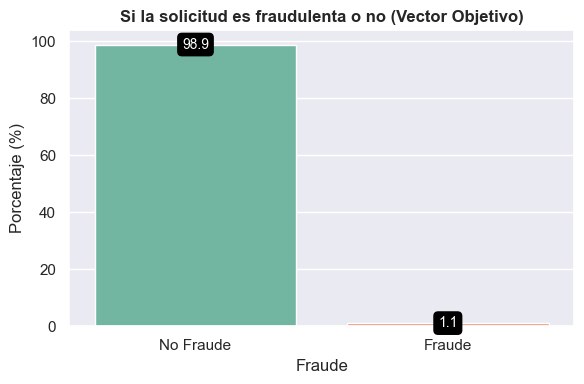

In [7]:
plt.figure(figsize=(6, 4))
fx_grafico_barra_simple('fraud_bool', df, 'Fraude', 'Porcentaje (%)', 'Si la solicitud es fraudulenta o no (Vector Objetivo)', 10, True, ['No Fraude', 'Fraude'])

### 1.3. EDA Variables Object (Categóricas)

In [8]:
# Vistazo general del dataframe de variables object categóricas
df.select_dtypes(exclude='number').head()

,income,customer_age,payment_type,employment_status,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,has_other_cards,foreign_request,source,device_os,keep_alive_session,month
0,d9,"(40, 50]",AA,CA,gratuito,BA,válido,no válido,sin tarjetas,no distinto,INTERNET,windows,No cierra sesión,7
1,d9,"(40, 50]",AB,CA,pago,BA,no válido,no válido,sin tarjetas,no distinto,INTERNET,windows,No cierra sesión,7
2,d9,"(30, 40]",AC,CB,pago,BA,no válido,válido,sin tarjetas,no distinto,INTERNET,other,No cierra sesión,7
3,d9,"(40, 50]",AB,CA,pago,BA,no válido,válido,con tarjetas,no distinto,INTERNET,linux,No cierra sesión,7
4,d9,"(40, 50]",AB,CA,pago,BA,válido,no válido,sin tarjetas,no distinto,INTERNET,macintosh,Cierra sesión,7


In [9]:
# Resumen descriptivo de las variables "object" categóricas
# El siguiente análisis descriptivo muestra la distribución de los datos (valores únicos, valores más frecuentes y la frecuencia por cada variable)

df.describe(exclude='number').transpose()

,count,unique,top,freq
income,993607,9,d9,220072
customer_age,993607,9,"(20, 30]",309288
payment_type,993607,5,AB,368115
employment_status,993607,7,CA,725305
email_is_free,993607,2,pago,526092
housing_status,993607,7,BC,368343
phone_home_valid,993607,2,no válido,578984
phone_mobile_valid,993607,2,válido,883950
has_other_cards,993607,2,sin tarjetas,771698
foreign_request,993607,2,no distinto,968498


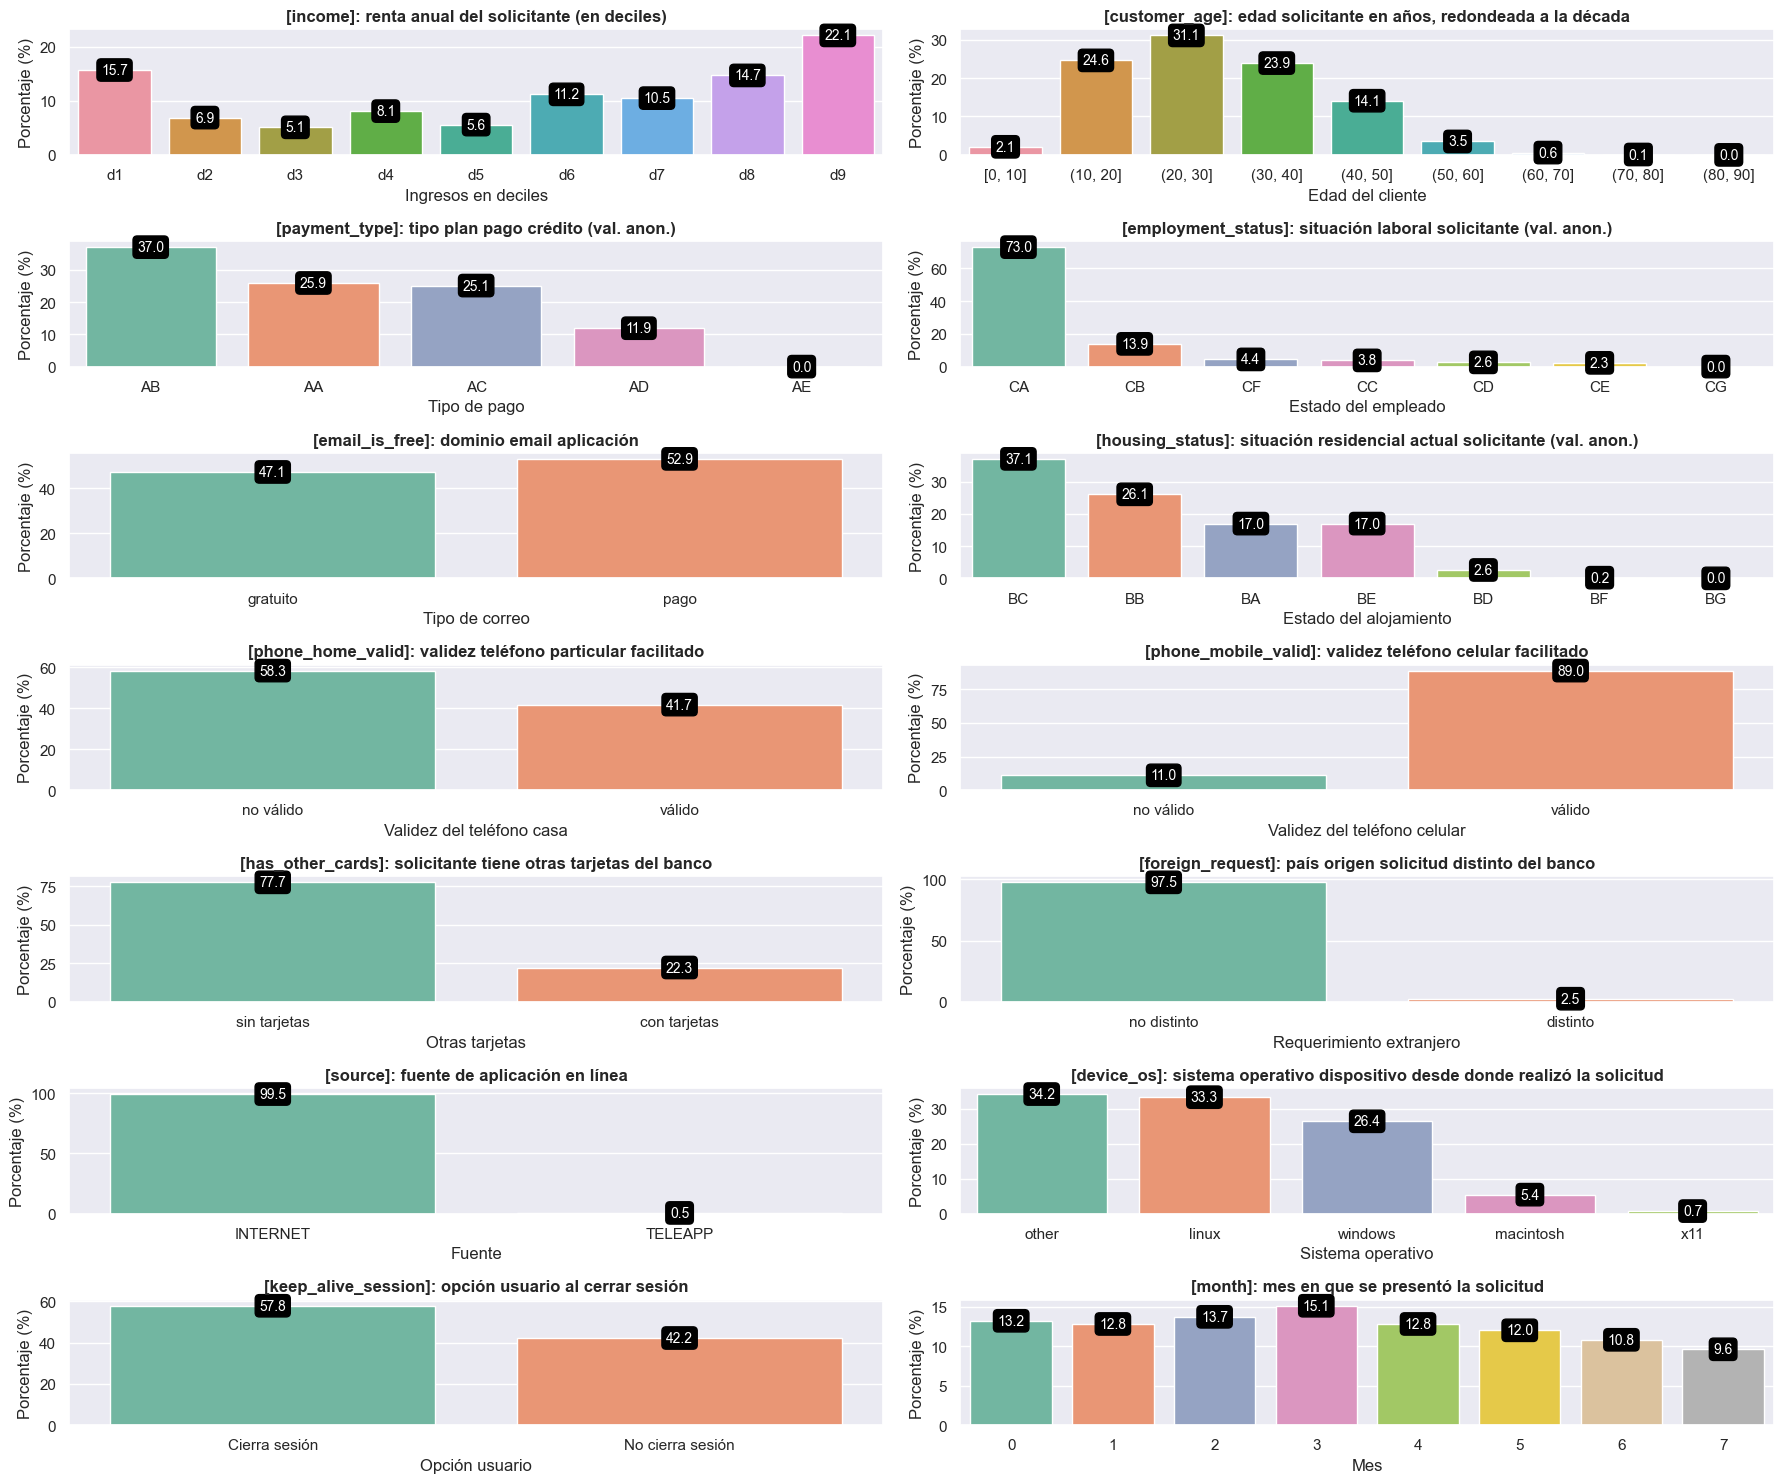

In [10]:
# Definiciones que se usarán en la función para graficar
lista_var_object = list(df.select_dtypes(exclude='number'))
orden_bool = [True, True, False, False, True, False, True, True, False, False, False, False, False, True]
lista_orden = [
  ['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9'],
  ['[0, 10]', '(10, 20]', '(20, 30]', '(30, 40]', '(40, 50]', '(50, 60]', '(60, 70]', '(70, 80]', '(80, 90]'],
  0,
  0,
  ['gratuito', 'pago'],
  0,
  ['no válido', 'válido'],
  ['no válido', 'válido'],
  0,
  0,
  0,
  0,
  0,
  ['0', '1', '2', '3', '4', '5', '6', '7'],
  ]
lista_nombres_eje_x = [
  'Ingresos en deciles',
  'Edad del cliente',
  'Tipo de pago',
  'Estado del empleado',
  'Tipo de correo',
  'Estado del alojamiento',
  'Validez del teléfono casa',
  'Validez del teléfono celular',
  'Otras tarjetas',
  'Requerimiento extranjero',
  'Fuente',
  'Sistema operativo',
  'Opción usuario',
  'Mes'
  ]

lista_titulos = [
  '[income]: renta anual del solicitante (en deciles)',
  '[customer_age]: edad solicitante en años, redondeada a la década',
  '[payment_type]: tipo plan pago crédito (val. anon.)',
  '[employment_status]: situación laboral solicitante (val. anon.)',
  '[email_is_free]: dominio email aplicación',
  '[housing_status]: situación residencial actual solicitante (val. anon.)',
  '[phone_home_valid]: validez teléfono particular facilitado',
  '[phone_mobile_valid]: validez teléfono celular facilitado',
  '[has_other_cards]: solicitante tiene otras tarjetas del banco',
  '[foreign_request]: país origen solicitud distinto del banco',
  '[source]: fuente de aplicación en línea',
  '[device_os]: sistema operativo dispositivo desde donde realizó la solicitud',
  '[keep_alive_session]: opción usuario al cerrar sesión',
  '[month]: mes en que se presentó la solicitud',
    ]

fx_grafico_barra_subplots(df, 2, (18, 15), lista_var_object, orden_bool, lista_orden, lista_nombres_eje_x, lista_titulos)

Todas las variables parecen interesantes a priori para la predicción. Únicamente "source" parece no aportar demasiado por su fuerte desbalance, sin embargo, se definirá si se usará o no por medio de la prueba de chi-cuadrado, al  determinar su grado de relación con el vector objetivo.

### 1.4. EDA variables númericas (Cuantitativas)

In [11]:
# Vistazo general del dataframe de variables numéricas cuantitativas
df.select_dtypes(include='number').drop('fraud_bool', axis=1).head()

,name_email_similarity,current_address_months_count,days_since_request,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,proposed_credit_limit,session_length_in_minutes,device_distinct_emails_8w,device_fraud_count
0,0.166828,88.0,0.020925,769,10650.765523,3134.319630,3863.647740,1,6,185,500,3.888115,1,0
1,0.296286,144.0,0.005418,366,534.047319,2670.918292,3124.298166,718,3,259,1500,31.798819,1,0
2,0.044985,132.0,3.108549,870,4048.534263,2893.621498,3159.590679,1,14,177,200,4.728705,1,0
3,0.159511,22.0,0.019079,810,3457.064063,4054.908412,3022.261812,1921,6,110,200,2.047904,1,0
4,0.596414,218.0,0.004441,890,5020.341679,2728.237159,3087.670952,1990,2,295,1500,3.775225,1,0


In [12]:
# Estadística descriptiva de las variables numéricas cuantitativas
pd.options.display.float_format = '{:.2f}'.format
df.drop('fraud_bool', axis=1).describe() # se excluye fraud_bool porque si bien es numérica, es de tipo categórica

,name_email_similarity,current_address_months_count,days_since_request,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,proposed_credit_limit,session_length_in_minutes,device_distinct_emails_8w,device_fraud_count
count,993607.00,993607.00,993607.00,993607.00,993607.00,993607.00,993607.00,993607.00,993607.00,993607.00,993607.00,993607.00,993607.00,993607.00
mean,0.49,86.96,1.02,1573.70,5668.11,4770.18,4856.81,184.85,9.50,131.04,516.30,7.56,1.02,0.00
std,0.29,88.41,5.36,1005.65,3009.48,1478.81,919.25,460.24,5.03,69.72,487.81,8.03,0.17,0.00
min,0.00,0.00,0.00,1.00,-170.60,1300.31,2825.75,0.00,0.00,-170.00,190.00,0.00,0.00,0.00
25%,0.23,20.00,0.01,895.00,3439.82,3594.04,4268.52,1.00,6.00,83.00,200.00,3.12,1.00,0.00
50%,0.49,53.00,0.02,1263.00,5323.29,4750.50,4913.61,9.00,9.00,122.00,200.00,5.12,1.00,0.00
75%,0.76,130.00,0.03,1945.00,7683.32,5752.20,5488.13,25.00,13.00,178.00,500.00,8.87,1.00,0.00
max,1.00,428.00,78.46,6700.00,16715.57,9506.90,6994.76,2385.00,39.00,389.00,2100.00,85.90,2.00,0.00


In [13]:
# Definición de las variables a gráficar. Se incluyen variables numéricas de hasta 12 valores únicos exceptuando al vector objetivo "fraud_bool", de modo de hacer más fácil la visualización

lista_var_hasta_12_val_unicos = df.select_dtypes(include='number') 
lista_var_hasta_12_val_unicos = lista_var_hasta_12_val_unicos.nunique()[lista_var_hasta_12_val_unicos.nunique()<=12].index.to_list()
lista_var_hasta_12_val_unicos.remove('fraud_bool')
lista_var_hasta_12_val_unicos

['proposed_credit_limit', 'device_distinct_emails_8w', 'device_fraud_count']

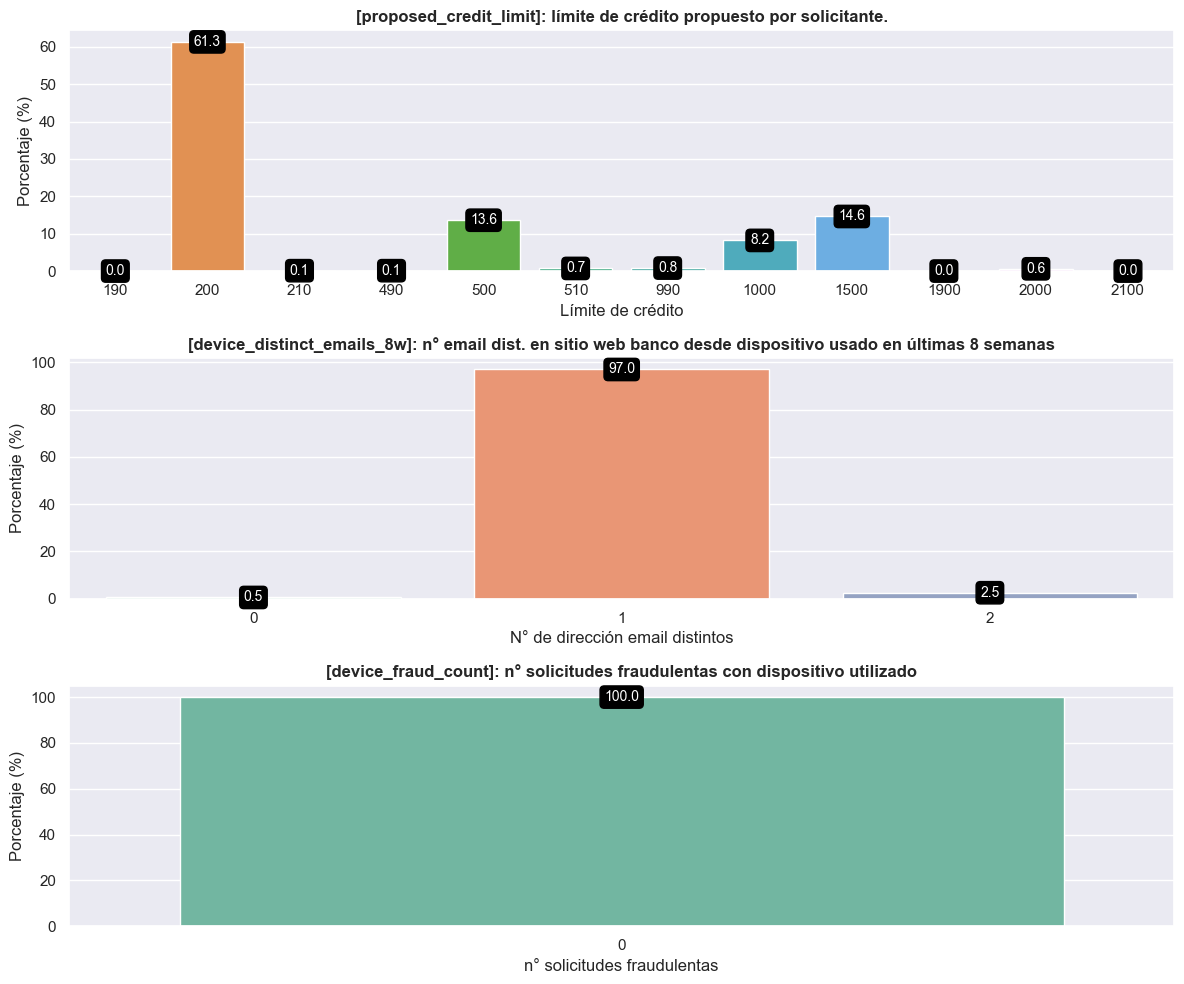

In [15]:
# Definiciones que se usarán luego en la función para graficar. Análisis a variables de hasta 12 valores únicos (para mejor visualización)
orden_bool = [False, False, False]
lista_orden = [0, 0, 0]

lista_nombres_eje_x = [
  'Límite de crédito',
  'N° de dirección email distintos',
  'n° solicitudes fraudulentas'
  ]

lista_titulos = [
  '[proposed_credit_limit]: límite de crédito propuesto por solicitante.',
  '[device_distinct_emails_8w]: n° email dist. en sitio web banco desde dispositivo usado en últimas 8 semanas',
  '[device_fraud_count]: n° solicitudes fraudulentas con dispositivo utilizado'
    ]

fx_grafico_barra_subplots(df, 1, (12, 10), lista_var_hasta_12_val_unicos, orden_bool, lista_orden, lista_nombres_eje_x, lista_titulos)

Respecto a las variables gráficadas, solo "device_fraud_count" no aportaría al modelo pues contiene un solo valor (0). Debido a que es claro que debe ser eliminada, se realizará inmediatamente esta operación.

In [16]:
# Eliminación de variable con un único valor
df.drop('device_fraud_count', axis=1, inplace=True)

In [17]:
# Definición de las variables a gráficar. Se incluyen variables numéricas sobre 12 valores únicos, de modo de hacer más fácil la visualización

lista_var_sobre_12_val_unicos = df.select_dtypes(include='number') 
lista_var_sobre_12_val_unicos = lista_var_sobre_12_val_unicos.nunique()[lista_var_sobre_12_val_unicos.nunique()>12].index.to_list()
lista_var_sobre_12_val_unicos

['name_email_similarity',
 'current_address_months_count',
 'days_since_request',
 'zip_count_4w',
 'velocity_6h',
 'velocity_24h',
 'velocity_4w',
 'bank_branch_count_8w',
 'date_of_birth_distinct_emails_4w',
 'credit_risk_score',
 'session_length_in_minutes']

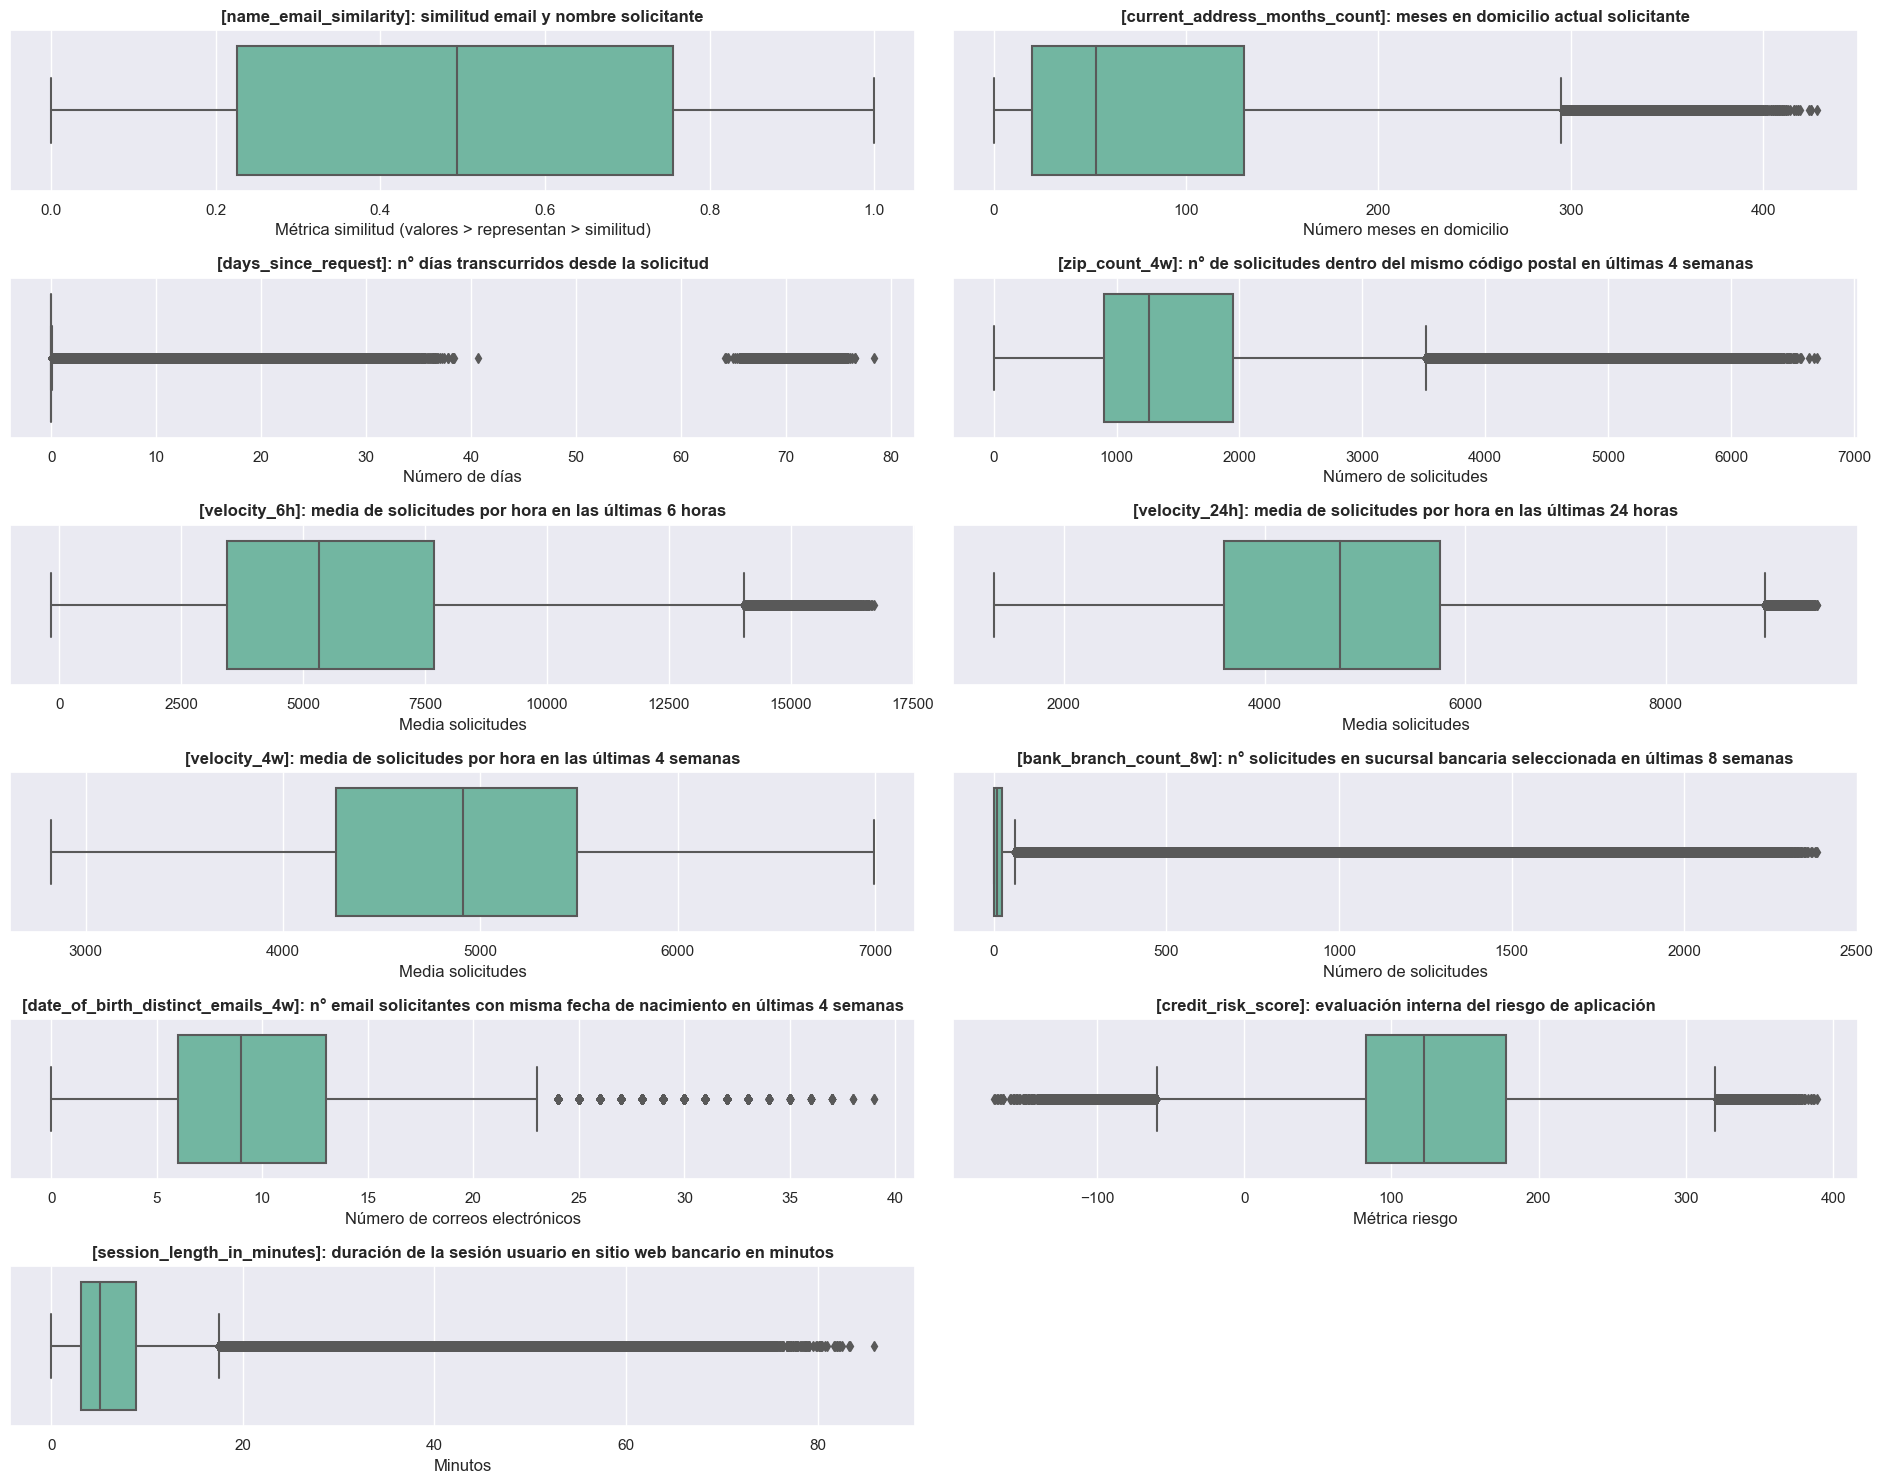

In [18]:
# Definiciones que se usarán luego en la función para graficar. Análisis a variables sobre 12 valores únicos (para mejor visualización)

lista_nombres_eje_x = [
  'Métrica similitud (valores > representan > similitud)',
  'Número meses en domicilio',
  'Número de días',
  'Número de solicitudes',
  'Media solicitudes',
  'Media solicitudes',
  'Media solicitudes',
  'Número de solicitudes',
  'Número de correos electrónicos',
  'Métrica riesgo',
  'Minutos'
  ]

lista_titulos = [
  '[name_email_similarity]: similitud email y nombre solicitante',
  '[current_address_months_count]: meses en domicilio actual solicitante',
  '[days_since_request]: n° días transcurridos desde la solicitud',
  '[zip_count_4w]: n° de solicitudes dentro del mismo código postal en últimas 4 semanas',
  '[velocity_6h]: media de solicitudes por hora en las últimas 6 horas',
  '[velocity_24h]: media de solicitudes por hora en las últimas 24 horas',
  '[velocity_4w]: media de solicitudes por hora en las últimas 4 semanas',
  '[bank_branch_count_8w]: n° solicitudes en sucursal bancaria seleccionada en últimas 8 semanas',
  '[date_of_birth_distinct_emails_4w]: n° email solicitantes con misma fecha de nacimiento en últimas 4 semanas',
  '[credit_risk_score]: evaluación interna del riesgo de aplicación',
  '[session_length_in_minutes]: duración de la sesión usuario en sitio web bancario en minutos'
  ]

fx_grafico_boxplot(df, 2, (19, 15), lista_var_sobre_12_val_unicos, lista_nombres_eje_x, lista_titulos)

Del gráfico superior se puede observar una gran cantidad de outliers (valores atípicos), sin embargo, no hay variables que se consideren que puedan ser eliminadas por esta razón. Debido a que nuestro modelo busca detectar comportamientos atípicos en la detección de fraude bancario, los outlier estarían aportando información valiosa para esta detección.

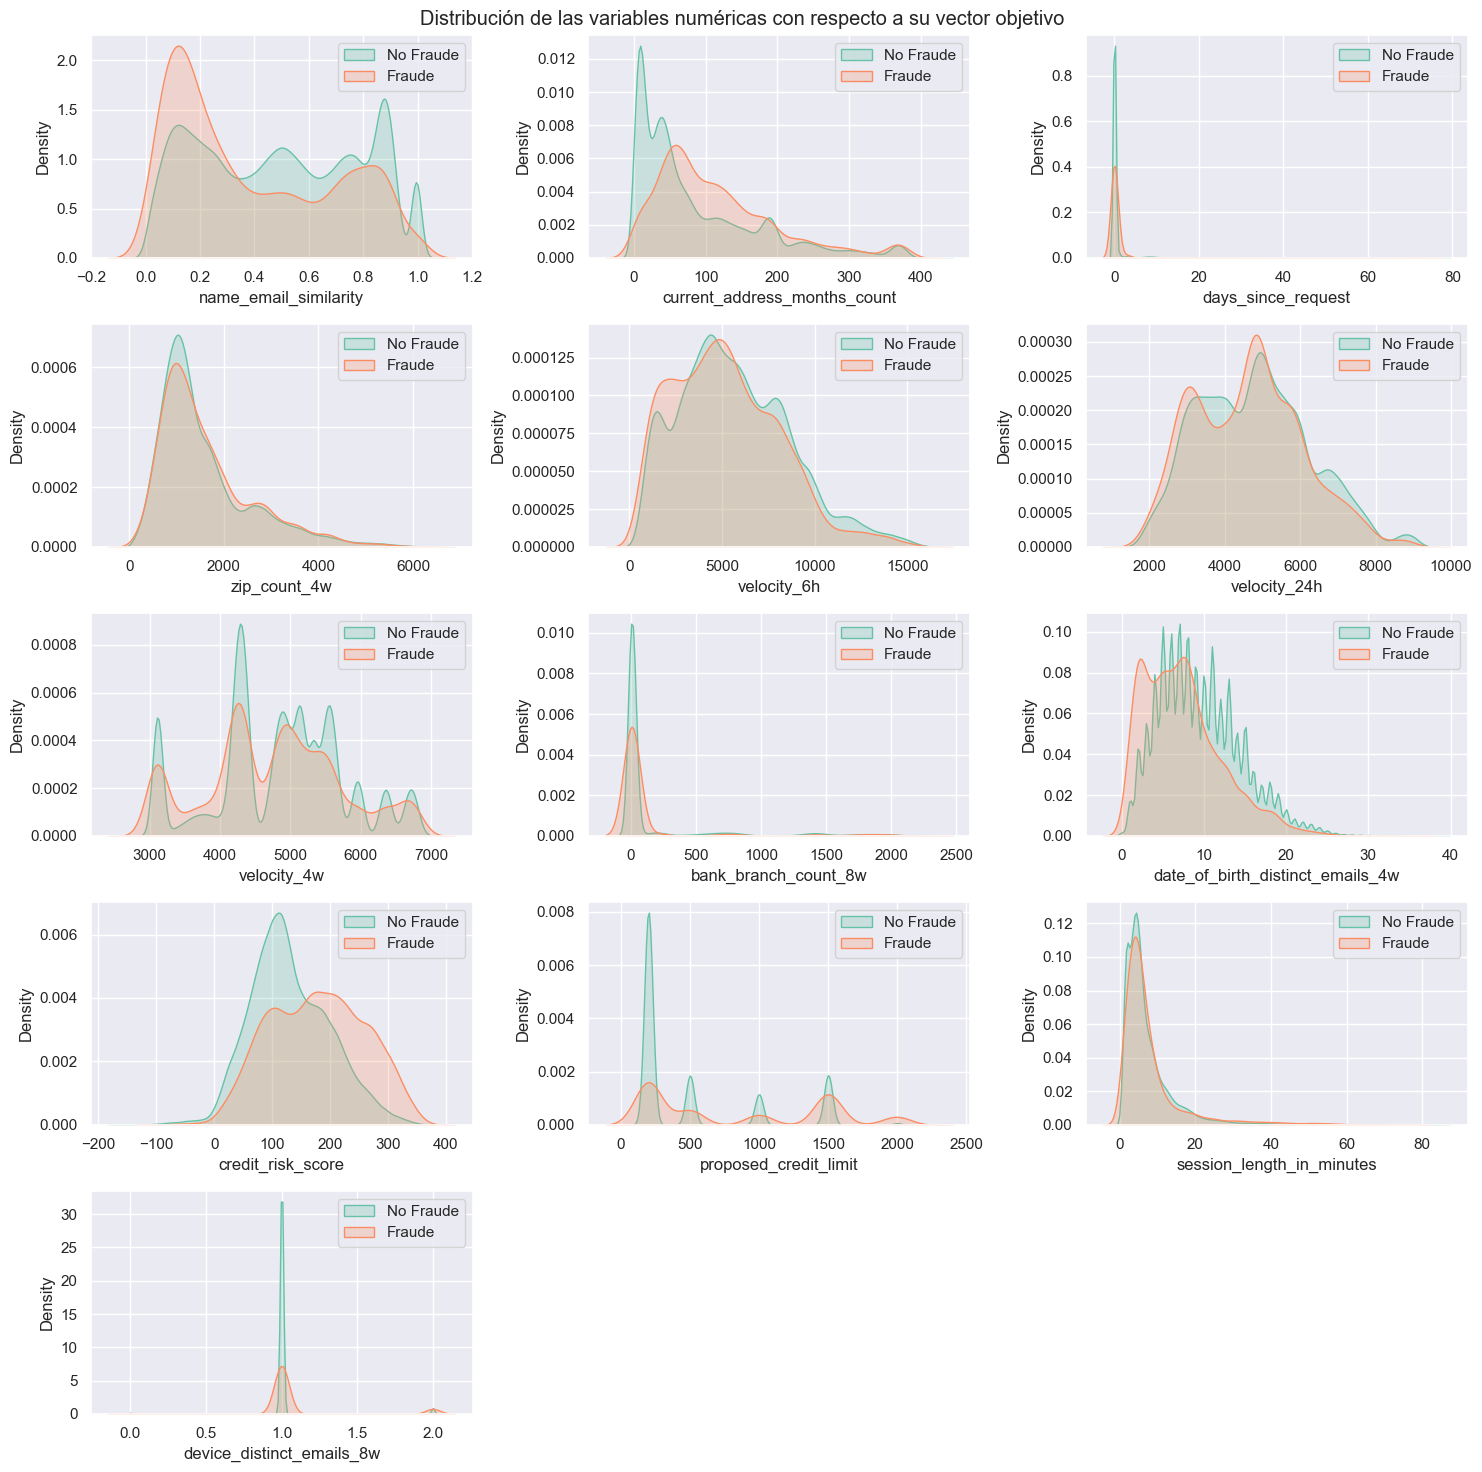

In [19]:
# Análisis general de variables numéricas

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 15))

fig.suptitle('Distribución de las variables numéricas con respecto a su vector objetivo')

for i, feature in enumerate(df.select_dtypes(include='number').drop('fraud_bool', axis=1).columns.to_list()):
    ax = axes[i // 3][i % 3]
    sns.kdeplot(data=df[df['fraud_bool'] == 0][feature], fill=True, ax=ax, label='No Fraude')
    sns.kdeplot(data=df[df['fraud_bool'] == 1][feature], fill=True, ax=ax, label='Fraude')
    ax.set_xlabel(feature)
    ax.legend()
fig.delaxes(axes[4,1]) # Se elimina subgráfico sin información
fig.delaxes(axes[4,2]) # Se elimina subgráfico sin información
plt.tight_layout()
plt.show()

De los gráficos se desprende de que hay algunas variables en donde el comportamiento respecto a las 2 clases del vector objetivo es similar, por lo que no aportarian significativamenre a la predicción, dichas variables son:
    
* zip_count_4w
* velocity_6h
* velocity_24h
* session_length_in_minutes

El resto de variables presenta una clara diferenciación para cada clase del vector objetivo, por lo que serian un aporte al modelo

In [20]:
# Estas variables se guardaran en una lista para posteriormente utilizarse. El nombre hace referencia a que se podrían eliminarse y que esta conclusión proviene del EDA
var_drop_eda = ['zip_count_4w', 'velocity_6h', 'velocity_24h', 'session_length_in_minutes']

### 1.5. Análisis de Relaciones Entre Variables

#### 1.5.1. Matriz de Correlaciones

La matriz de correlaciones solo se realizará sobre aquellas variables que no son categóricas.

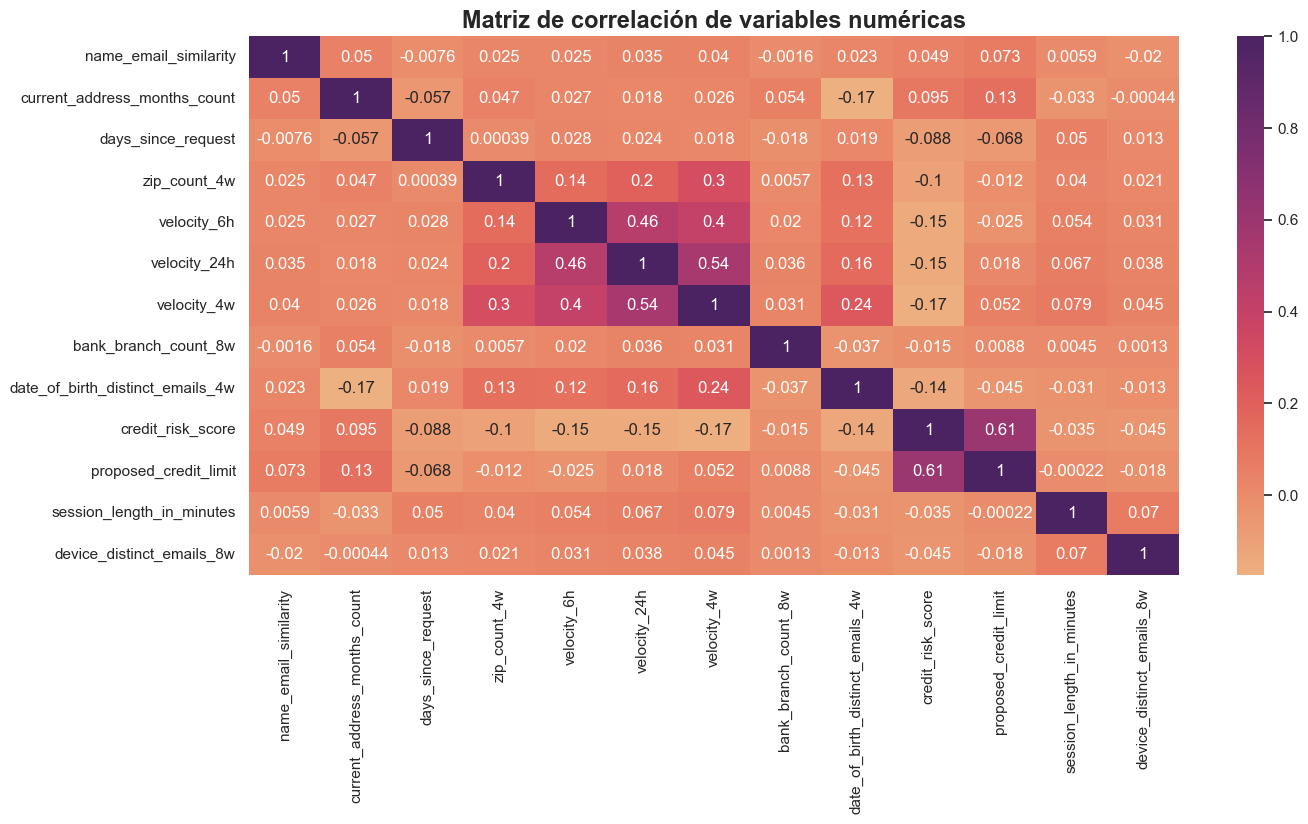

In [21]:
plt.figure(figsize=(15, 7))

# Calcular la matriz de correlación
correlation_matrix = df.select_dtypes(include='number').drop('fraud_bool', axis=1).corr() # fraud_bool se excluye por ser categórica booleana (0 y 1)

# Visualizar la matriz de correlación usando un mapa de calor
sns.heatmap(correlation_matrix, annot=True, cmap='flare')
plt.title('Matriz de correlación de variables numéricas', fontweight='bold', fontsize=17)
plt.show()

In [22]:
# Para detectar correlaciones sobre un umbral de 0,5

matrix_sobre_valor = correlation_matrix[correlation_matrix>0.5]

for columna in range(matrix_sobre_valor.shape[1]):
    for fila in range(matrix_sobre_valor.shape[1]):
        if pd.notna(matrix_sobre_valor.iloc[fila, columna]) & (matrix_sobre_valor.iloc[fila, columna] != 1):
            resultado = 'fila ' + str(matrix_sobre_valor.index[fila]) + ' y columna ' + str(matrix_sobre_valor.columns[columna]) + ' da un ' + str(round(matrix_sobre_valor.iloc[fila,columna], 2)) + ' de correlación'
            print(f'{matrix_sobre_valor.index[fila]} y {matrix_sobre_valor.columns[columna]} da un {round(matrix_sobre_valor.iloc[fila,columna], 2)} de correlación')

velocity_4w y velocity_24h da un 0.54 de correlación
velocity_24h y velocity_4w da un 0.54 de correlación
proposed_credit_limit y credit_risk_score da un 0.61 de correlación
credit_risk_score y proposed_credit_limit da un 0.61 de correlación


Del análisis de correlaciones no parecen haber variables que esten fuertemente correlaciones entre si para plantear la necesidad de eliminar algunas de ellas por esta causa. Los casos más fuertes de correlaciones están entre velocity_4w y velocity_24h (0,54 de correlación), y entre proposed_credit_limit y credit_risk_score (0,61% de correlación).

#### 1.5.2. Prueba de Chi-Cuadrado

In [23]:
# Realizar la prueba de chi-cuadrado entre cada variable categórica y la variable objetivo
correlation_results = []

for col in df.select_dtypes(exclude='number').columns.to_list():
    contingency_table = pd.crosstab(df.select_dtypes(exclude='number')[col], df['fraud_bool'].astype(str))
    chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)
    correlation_results.append({'Variable': col, 'Chi2': chi2, 'p-value': p_value})

# Mostrar los resultados de correlación
correlation_df = pd.DataFrame(correlation_results)
correlation_df.sort_values(by='Chi2').reset_index(drop=True)

,Variable,Chi2,p-value
0,source,23.80,0.00
1,phone_mobile_valid,174.05,0.00
2,foreign_request,285.76,0.00
3,month,332.18,0.00
4,email_is_free,767.50,0.00
5,has_other_cards,1233.20,0.00
6,phone_home_valid,1235.82,0.00
7,payment_type,1536.76,0.00
8,employment_status,1568.66,0.00
9,keep_alive_session,2528.45,0.00


Dado que el p-valor en todas las variables es menor a un umbral de 0.05 (asumiendo un máximo de 5% de error), se constata una fuerte evidencia en contra de la hipótesis nula de independencia entre las variables categóricas y la variable objetivo. Sin embargo, se considera que las variables con menor Chi2 (source, phone_mobile_valid, foreign_request, month y email_is_free) pueden estar menos relacionada a la variable objetivo y, por lo tanto, podrian eventualmente eliminarse.

In [24]:
# Estas variables se guardaran en una lista para posteriormente utilizarse. El nombre hace referencia a que se podrían eliminarse y que esta conclusión proviene del análisis de Chi-Cuadrado
var_drop_chi2 =  ['source', 'phone_mobile_valid', 'foreign_request', 'month', 'email_is_free']

### 1.5. Conclusiones EDA

Las conclusiones del EDA son las siguientes:
    
* Se eliminó la variable device_fraud_count ya que contenia un solo valor (0), por lo que no aportaría al modelo.
* Las variables zip_count_4w, velocity_6h, velocity_24h y session_length_in_minutes parecerian no aportar demasiado a la predicción, ya que su comportamiento es similar en ambas clases del vector objetivo. Se evaluarán los modelos con y sin estás variables. Estas variables se guardaron en una lista llamada var_drop_eda.
* Las variables source, phone_mobile_valid, foreign_request, month y email_is_free presentan un bajo chi-cuadrado, aunque su relación con el vector objetivo si fue significativa. Se evaluarán los modelos con y sin estás variables. Estas variables se guardaron en una lista llamada var_drop_chi2.
* La cantidad de outliers presentes en las variables numéricas no se considera un problema, ya que nuestro modelo se basa en detectar fraude en el que hay presente comportamientos atípicos.

In [25]:
print(f'Variables a eliminar por EDA en el modelamiento ({len(var_drop_eda)}): {", ".join(var_drop_eda)}.\nVariables a eliminar por Chi-Cuadrado en el modelamiento ({len(var_drop_chi2)}): {", ".join(var_drop_chi2)}.')

Variables a eliminar por EDA en el modelamiento (4): zip_count_4w, velocity_6h, velocity_24h, session_length_in_minutes.
Variables a eliminar por Chi-Cuadrado en el modelamiento (5): source, phone_mobile_valid, foreign_request, month, email_is_free.


# 2. Pre-Procesamiento (Normalización de las variables numéricas)

Las variables a normalizar son todas las numéricas, ya sean cuantitativas o categóricas

In [26]:
var_normalizar = list(df.select_dtypes(include='number').drop('fraud_bool', axis=1))
var_normalizar

['name_email_similarity',
 'current_address_months_count',
 'days_since_request',
 'zip_count_4w',
 'velocity_6h',
 'velocity_24h',
 'velocity_4w',
 'bank_branch_count_8w',
 'date_of_birth_distinct_emails_4w',
 'credit_risk_score',
 'proposed_credit_limit',
 'session_length_in_minutes',
 'device_distinct_emails_8w']

In [27]:
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df[var_normalizar]), columns=list(df[var_normalizar]))
df.drop(list(df[var_normalizar]), axis=1, inplace=True) # se elimina variables númericas para ser reemplazadas por las variables escaladas
df = pd.concat([df.reset_index(drop=True), scaled_df.reset_index(drop=True)], axis=1) # se vuelven a unir reemplazando el df original
df.head()

,fraud_bool,income,customer_age,payment_type,employment_status,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,has_other_cards,...,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,proposed_credit_limit,session_length_in_minutes,device_distinct_emails_8w
0,1,d9,"(40, 50]",AA,CA,gratuito,BA,válido,no válido,sin tarjetas,...,-0.80,1.66,-1.11,-1.08,-0.40,-0.70,0.77,-0.03,-0.46,-0.12
1,1,d9,"(40, 50]",AB,CA,pago,BA,no válido,no válido,sin tarjetas,...,-1.20,-1.71,-1.42,-1.88,1.16,-1.29,1.84,2.02,3.02,-0.12
2,1,d9,"(30, 40]",AC,CB,pago,BA,no válido,válido,sin tarjetas,...,-0.70,-0.54,-1.27,-1.85,-0.40,0.89,0.66,-0.65,-0.35,-0.12
3,1,d9,"(40, 50]",AB,CA,pago,BA,no válido,válido,con tarjetas,...,-0.76,-0.73,-0.48,-2.00,3.77,-0.70,-0.30,-0.65,-0.69,-0.12
4,1,d9,"(40, 50]",AB,CA,pago,BA,válido,no válido,sin tarjetas,...,-0.68,-0.22,-1.38,-1.92,3.92,-1.49,2.35,2.02,-0.47,-0.12


# 3. Feature Engineering

Los modelos requieren que la data sea numérica, por lo que se realizará una transformación a las variables object para que se cumpla con este requisito. La transformación escogida es One Hot Encoder (OHE), debido a que no hay una relación ordinal en las clases de las variables. Algunos de los modelos que se utilizarán pueden interpretar que el valor 1 tiene más peso que 0, por esa razón se escogio OHE.

In [28]:
variables_ohe = list(df.select_dtypes(exclude='number'))
variables_ohe

['income',
 'customer_age',
 'payment_type',
 'employment_status',
 'email_is_free',
 'housing_status',
 'phone_home_valid',
 'phone_mobile_valid',
 'has_other_cards',
 'foreign_request',
 'source',
 'device_os',
 'keep_alive_session',
 'month']

Se utilizará el objeto OneHotEncoder de scikit-learn en vez del método get_dummies de pandas. La razón es que computacionalmente es más eficiente OHE de scikit-learn para grandes volumenes de datos.

In [29]:
onehot_encoder = OneHotEncoder(sparse=False)
df_ohe = pd.DataFrame(onehot_encoder.fit_transform(df[variables_ohe]), columns=onehot_encoder.get_feature_names_out()) # Para pasar el array a un dataframe y restituir el nombre de las columnas
df.drop(list(df[variables_ohe]), axis=1, inplace=True) # se elimina variables transformadas del df original para ser reemplazadas por las variables transformadas
df = pd.concat([df, df_ohe], axis=1) # se vuelven a unir reemplazando el df original
df.head()

,fraud_bool,name_email_similarity,current_address_months_count,days_since_request,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,...,keep_alive_session_Cierra sesión,keep_alive_session_No cierra sesión,month_0,month_1,month_2,month_3,month_4,month_5,month_6,month_7
0,1,-1.13,0.01,-0.19,-0.80,1.66,-1.11,-1.08,-0.40,-0.70,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
1,1,-0.68,0.65,-0.19,-1.20,-1.71,-1.42,-1.88,1.16,-1.29,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
2,1,-1.55,0.51,0.39,-0.70,-0.54,-1.27,-1.85,-0.40,0.89,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
3,1,-1.16,-0.73,-0.19,-0.76,-0.73,-0.48,-2.00,3.77,-0.70,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
4,1,0.35,1.48,-0.19,-0.68,-0.22,-1.38,-1.92,3.92,-1.49,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00


# 4. Separación de la data

Como se mencionó en secciones previas, se utilizará una estrategia de evaluar los modelos según los siguientes criterios:
* Evaluar la data completa, es decir, sin eliminación de variables
* Evaluar la data eliminando las variables que en el EDA se determinó no aportarían de forma sustancial a la predicción (variables almacenadas en lista var_drop_eda)
* Evaluar la data eliminando las variables que en la prueba Chi-Cuadrado se determinó no aportarían de forma sustancial a la predicción (variables almacenadas en lista var_drop_chi2)
* Evaluar la data eliminando todas las variables que en el EDA y en la prueba Chi-Cuadrado se determinó no aportarían de forma sustancial a la predicción (variables almacenadas en listas var_drop_eda y var_drop_chi2)

De este modo la separación de la data en train y test seguirá esta lógica, por lo que habrán 4 versiones del train y test para poder llevar a cabo esta estrategia. Finalmente determinaremos si las variables aportan o no al modelamiento de forma empírica.

In [30]:
######## 1 -----> Separación de la data manteniendo todas las variables 

X_train, X_test, y_train, y_test = fx_train_test_split(df)[0], fx_train_test_split(df)[1], fx_train_test_split(df)[2], fx_train_test_split(df)[3]

######## 2 -----> Separación de la data eliminando variables que se definió no aportaban a la predicción en el EDA
df_var_drop_eda = df.copy(deep=True)
df_var_drop_eda.drop(var_drop_eda, axis=1, inplace=True)

X_train_var_drop_eda, X_test_var_drop_eda, y_train_var_drop_eda, y_test_var_drop_eda = fx_train_test_split(df_var_drop_eda)[0], fx_train_test_split(df_var_drop_eda)[1], fx_train_test_split(df_var_drop_eda)[2], fx_train_test_split(df_var_drop_eda)[3]

####### 3 -----> Separación de la data eliminando variables que se definió no aportaban a la predicción en la prueba de Chi-Cuadrado
df_var_drop_chi2 = df.copy(deep=True)

# se debe hacer un paso adicional. La lista que se guardo llamada var_drop_chi2 ya no es válida, ya que los nombres de esas variables cambiaron al aplicar el OHE (se mantuvo el nombre + el nombre de la clase),
# para esto se realizará una operación para obtener el nuevo nombre a partir de una busqueda del nombre original (si el nombre de las columnas contiene o no el nombre original) en las columnas del df
new_var_drop_chi2 = [] # nuevo nombre de la lista

for i in var_drop_chi2:
    for p in ([element for element in list(df_var_drop_chi2) if i+'_' in element]):
        new_var_drop_chi2.append(p)

df_var_drop_chi2.drop(new_var_drop_chi2, axis=1, inplace=True)

X_train_var_drop_chi2, X_test_var_drop_chi2, y_train_var_drop_chi2, y_test_var_drop_chi2 = fx_train_test_split(df_var_drop_chi2)[0], fx_train_test_split(df_var_drop_chi2)[1], fx_train_test_split(df_var_drop_chi2)[2], fx_train_test_split(df_var_drop_chi2)[3]

####### 4 -----> Separación de la data eliminando variables que se definió no aportaban a la predicción en el EDA y en la prueba de Chi-Cuadrado (se fusionan las 2 listas de variables)

df_var_drop_all = df.copy(deep=True)
df_var_drop_all.drop(var_drop_eda+new_var_drop_chi2, axis=1, inplace=True)

X_train_var_drop_all, X_test_var_drop_all, y_train_var_drop_all, y_test_var_drop_all = fx_train_test_split(df_var_drop_all)[0], fx_train_test_split(df_var_drop_all)[1], fx_train_test_split(df_var_drop_all)[2], fx_train_test_split(df_var_drop_all)[3]

### 4.1 Balanceo de clases

Adicional a la separación de la data en 4 versiones, según se haya hecho o no eliminación de variables (y cuales variables se eliminaron), se adiciona un nuevo nivel de separación según se haya hecho o no un balanceo de clases. Esta técnica busca sobre-representar la clase minoritaria o reducir la mayoriatia, a fin de evitar un sesgo hacia las clases dominantes y mejorar el rendimiento del modelo al predecir clases minoritarias.     

Por lo tanto, cada una de las 4 versiones de la data de train y test tendrá 3 subversiones, la base sin balanceo de clases, una con sobre-representación de la clase minoritaria (over-sampler) y una con reducción de la clase mayoritaria (under-sampler): 

**GRUPO 1**
* Xy train y test sin eliminación de variables
* Xy train y test sin eliminación de variables con over-sampler
* Xy train y test sin eliminación de variables con under-sampler
  
**GRUPO 2**
* Xy train y test sin las variables que se definió no aportarian en el EDA
* Xy train y test sin las variables que se definió no aportarian en el EDA con over-sampler
* Xy train y test sin las variables que se definió no aportarian en el EDA con under-sampler

**GRUPO 3**
* Xy train y test sin las variables que se definió no aportarian en la prueba Chi-Cuadrado
* Xy train y test sin las variables que se definió no aportarian en la prueba Chi-Cuadrado con over-sampler
* Xy train y test sin las variables que se definió no aportarian en la prueba Chi-Cuadrado con under-sampler

**GRUPO 4**
* Xy train y test sin las variables que se definió no aportarian en el EDA y en la prueba Chi-Cuadrado
* Xy train y test sin las variables que se definió no aportarian en el EDA y la prueba Chi-Cuadrado con over-sampler
* Xy train y test sin las variables que se definió no aportarian en el EDA y en la prueba Chi-Cuadrado con under-sampler

In [31]:
# GRUPO 1
# X_train e y_train definidas en el chunck anterior
X_train_os, y_train_os = RandomOverSampler(random_state=42).fit_resample(X_train, y_train)
X_train_us, y_train_us = RandomUnderSampler(random_state=42).fit_resample(X_train, y_train)

# GRUPO 2
# X_train_var_drop_eda e y_train_var_drop_eda definidas en el chunck anterior
X_train_var_drop_eda_os, y_train_var_drop_eda_os = RandomOverSampler(random_state=42).fit_resample(X_train_var_drop_eda, y_train_var_drop_eda)
X_train_var_drop_eda_us, y_train_var_drop_eda_us = RandomUnderSampler(random_state=42).fit_resample(X_train_var_drop_eda, y_train_var_drop_eda)

# GRUPO 3
# X_train_var_drop_chi2 e y_train_var_drop_chi2 definidas en el chunck anterior
X_train_var_drop_chi2_os, y_train_var_drop_chi2_os = RandomOverSampler(random_state=42).fit_resample(X_train_var_drop_chi2, y_train_var_drop_chi2)
X_train_var_drop_chi2_us, y_train_var_drop_chi2_us = RandomUnderSampler(random_state=42).fit_resample(X_train_var_drop_chi2, y_train_var_drop_chi2)

# GRUPO 2
# X_train_var_drop_all e y_train_var_drop_all definidas en el chunck anterior
X_train_var_drop_all_os, y_train_var_drop_all_os = RandomOverSampler(random_state=42).fit_resample(X_train_var_drop_all, y_train_var_drop_all)
X_train_var_drop_all_us, y_train_var_drop_all_us = RandomUnderSampler(random_state=42).fit_resample(X_train_var_drop_all, y_train_var_drop_all)

In [32]:
print(f"""El over-sampler sobre representa la clase mayoritaria, por lo tanto, de los {X_train.shape[0]} registros originales del X_train, el número de registros aumentan a {X_train_os.shape[0]} ({round(X_train_os.shape[0]/X_train.shape[0]*100,1)}% de la data original). 
Respecto a la proporción del vector objetivo, este pasa de la proporción original de {round(y_train.value_counts(normalize=True)[0]*100, 1)}% no fraude/{round(y_train.value_counts(normalize=True)[1]*100, 1)}% fraude a {round(y_train_os.value_counts(normalize=True)[0]*100, 1)}% no fraude/{round(y_train_os.value_counts(normalize=True)[1]*100, 1)}% fraude.

Por otra parte, el under-sampler reduce los registros al reducir la influencia de la clase mayoritaria, quedando un total de {X_train_us.shape[0]} registros ({round(X_train_us.shape[0]/X_train.shape[0]*100,1)}% de la data original).
La proporción de clases queda de la misma forma que en el over-sampler, es decir, {round(y_train_os.value_counts(normalize=True)[0]*100, 1)}% no fraude/{round(y_train_os.value_counts(normalize=True)[1]*100, 1)}% fraude.""")

El over-sampler sobre representa la clase mayoritaria, por lo tanto, de los 794885 registros originales del X_train, el número de registros aumentan a 1572178 (197.8% de la data original). 
Respecto a la proporción del vector objetivo, este pasa de la proporción original de 98.9% no fraude/1.1% fraude a 50.0% no fraude/50.0% fraude.

Por otra parte, el under-sampler reduce los registros al reducir la influencia de la clase mayoritaria, quedando un total de 17592 registros (2.2% de la data original).
La proporción de clases queda de la misma forma que en el over-sampler, es decir, 50.0% no fraude/50.0% fraude.


# 5. Modelamiento

Debido al gran número de modelos que se ejecutarán, y para mantener un orden, el modelamiente se dividirán en 2 grandes grupos. En la sección 5.1 se abordarán aquellos modelos a los cuales no se les eliminarán variables, es decir, se ocuparán todas las variables post EDA (pre-EDA se eliminaron 'intended_balcon_amount', 'prev_address_months_count' y 'bank_months_count' por tener demasiados NaN. En EDA se eliminó 'device_fraud_count' por tener un único valor "0"). En esta sección 5.1 se ejecutarán, para cada modelo, una versión sin balanceo de clases, una con over-sampler y una con under-sampler. A todos estos modelos se les almacenarán sus metricas de rendimiento y se determinarán los mejores modelos, los cuales serán un máximo de 3. La sección 5.2 tomará los mejores 3 modelos de la sección 5.1, y se evaluará para cada modelo una versión sin las variables que se definió podrian no aportar significativamente a la predicción desde el EDA (variables guardadas en la lista var_drop_eda), sin las variables que se definió podrian no aportar significativamente a la predicción desde la prueba Chi-Cuadrado (variables guardadas en la lista var_drop_chi2) y finalmente se evaluarán los modelos sin ambos grupos de variables (la suma de las listas var_drop_eda y var_drop_chi2). Finalmente el modelado quedaría de la siguiente forma:

**Sección 5.1 con todas las variables**
* Modelo_1 
  * Modelo_1 sin balanceo de clases
  * Modelo_1 con over-sampler
  * Modelo_1 con under_sampler
* Modelo_2 y sucecivos modelos de la sección mantienen estrucura de Modelo_1
Se obtiene los mejores 3 modelos que pasarán a la siguiente sección. **Los mejores modelos consideran el tipo de modelo (regresión logística, naive bayes, etc.) + si se utiliza o no balanceo de clases.**

**Sección 5.2 eliminando variables**
* Modelo_1 
  * Modelo_1 sin variables var_drop_eda
  * Modelo_1 sin variables var_drop_chi2
  * Modelo_1 sin variables var_drop_eda y var_drop_chi2
* Modelo_2
  * Modelo_1 sin variables var_drop_eda
  * Modelo_1 sin variables var_drop_chi2
  * Modelo_1 sin variables var_drop_eda y var_drop_chi2
* Modelo_3 
  * Modelo_1 sin variables var_drop_eda
  * Modelo_1 sin variables var_drop_chi2
  * Modelo_1 sin variables var_drop_eda y var_drop_chi2        

Se define la mejor combinación como **tipo de modelo (regresión logística, naive bayes, etc.) + si se utiliza o no balanceo de clases + variables eliminadas o no**.

#### Métricas a evaluar

Respecto a las métricas a evaluar, se generarán el accuracy, precision, recall, f1 y auc_roc. Sin embargo, para definir si un modelo es exitoso en su desempeño se tomará en cuenta el auc-roc.

Al seleccionar la métrica de desempeño adecuada para nuestro modelo de detección de fraude bancario, es importante tener en cuenta la naturaleza desbalanceada de nuestro conjunto de datos, donde el 99% de las muestras corresponden a la clase negativa (no fraude) y solo el 1% pertenece a la clase positiva (fraude). En este escenario, es crucial elegir una métrica que pueda evaluar correctamente el rendimiento del modelo en ambas clases y que sea robusta frente al desequilibrio de clases.

El AUC-ROC (Área bajo la curva de característica operativa del receptor) se destaca como una métrica adecuada para nuestro problema. El AUC-ROC considera tanto la tasa de verdaderos positivos como la tasa de falsos positivos a través de diferentes umbrales de clasificación. Al calcular el área bajo la curva ROC, esta métrica proporciona una medida global del rendimiento del modelo para clasificar correctamente las muestras en ambas clases.

Dado el desbalance en nuestro conjunto de datos, el AUC-ROC es especialmente útil porque no solo se basa en la tasa de verdaderos positivos, sino que también tiene en cuenta la tasa de falsos positivos. Esto es relevante, ya que en la detección de fraude, queremos minimizar los falsos positivos (casos no fraudulentos clasificados incorrectamente como fraudulentos) para evitar inconvenientes innecesarios para los clientes y garantizar la confianza en el sistema de detección.

Si bien es importante tener en cuenta el recall (tasa de verdaderos positivos) como métrica para evaluar el desempeño de nuestro modelo de detección de fraude, en el proceso de selección y comparación de múltiples modelos, se utilizará el AUC-ROC como métrica principal para clasificar los modelos.

La razón detrás de esta elección radica en el hecho de que el AUC-ROC considera el rendimiento del modelo en todas las clases y proporciona una medida global del poder discriminativo del modelo. Al evaluar y clasificar varios modelos de detección de fraude, el AUC-ROC nos permite comparar su capacidad para distinguir entre las clases positiva y negativa, teniendo en cuenta tanto la sensibilidad como la especificidad del modelo. Esto nos ayuda a seleccionar el modelo que mejor equilibre la detección precisa de los casos de fraude con la minimización de los falsos positivos.

En conclusión, en nuestro modelo de detección de fraude bancario con un vector objetivo desbalanceado, utilizaremos el AUC-ROC como métrica de desempeño principal para evaluar y seleccionar los modelos. Si bien el recall es importante para garantizar una alta tasa de detección de fraudes, el AUC-ROC nos permite tener una visión general del rendimiento de los modelos en todas las clases y nos ayuda a encontrar el equilibrio óptimo entre la precisión y la minimización de los falsos positivos en nuestro sistema de detección de fraude.

## 5.1. Modelamiento con todas las variables

In [33]:
# Esta lista es para iterar dentro de la fx que produce el modelamiento
lista_X_train = [X_train, X_train_os, X_train_us]
lista_y_train = [y_train, y_train_os, y_train_us]

### 5.1.1. Modelos Supervisados (sin y con balanceo de clases)

#### 5.1.1.1. Regresión Logística

In [ ]:
# lista_nombres_modelos = ['reg_log', 'reg_log_over_sampler', 'reg_log_under_sampler']
# fx_modelos_con_sin_balanceo_clases(lista_nombres_modelos, LogisticRegression(n_jobs=-1), lista_X_train, lista_y_train)

In [37]:
# Se almacenan las métricas en variables para luego consolidarlas en un único dataframe
reg_log_metricas = fx_metricas('reg_log.pkl', 'supervisado', X_test, y_test)
reg_log_over_sampler_metricas = fx_metricas('reg_log_over_sampler.pkl', 'supervisado', X_test, y_test)
reg_log_under_sampler_metricas = fx_metricas('reg_log_under_sampler.pkl', 'supervisado', X_test, y_test)

#### 5.1.1.2. Árbol de Decisión

In [ ]:
# lista_nombres_modelos = ['arbol', 'arbol_over_sampler', 'arbol_under_sampler']
# fx_modelos_con_sin_balanceo_clases(lista_nombres_modelos, DecisionTreeClassifier(), lista_X_train, lista_y_train)

In [38]:
# Se almacenan las métricas en variables para luego consolidarlas en un único dataframe
arbol_metricas = fx_metricas('arbol.pkl', 'supervisado', X_test, y_test)
arbol_over_sampler_metricas = fx_metricas('arbol_over_sampler.pkl',  'supervisado', X_test, y_test)
arbol_under_sampler_metricas = fx_metricas('arbol_under_sampler.pkl', 'supervisado',  X_test, y_test)

#### 5.1.1.3. Support Vector Machine Classifier (SVC)

In [ ]:
# lista_nombres_modelos = ['svc', 'svc_over_sampler', 'svc_under_sampler']
# fx_modelos_con_sin_balanceo_clases(lista_nombres_modelos, SVC(kernel='linear', max_iter=10000), lista_X_train, lista_y_train)

In [39]:
# Se almacenan las métricas en variables para luego consolidarlas en un único dataframe
svc_metricas = fx_metricas('svc.pkl',  'supervisado', X_test, y_test)
svc_over_sampler_metricas = fx_metricas('svc_over_sampler.pkl', 'supervisado', X_test, y_test)
svc_under_sampler_metricas = fx_metricas('svc_under_sampler.pkl', 'supervisado', X_test, y_test)

#### 5.1.1.4. Random Forest

In [ ]:
# lista_nombres_modelos = ['forest', 'forest_over_sampler', 'forest_under_sampler']
# fx_modelos_con_sin_balanceo_clases(lista_nombres_modelos, RandomForestClassifier(n_jobs=-1), lista_X_train, lista_y_train)

In [40]:
# Se almacenan las métricas en variables para luego consolidarlas en un único dataframe
forest_metricas = fx_metricas('forest.pkl', 'supervisado', X_test, y_test)
forest_over_sampler_metricas = fx_metricas('forest_over_sampler.pkl', 'supervisado', X_test, y_test)
forest_under_sampler_metricas = fx_metricas('forest_under_sampler.pkl', 'supervisado', X_test, y_test)

#### 5.1.1.5. Naïve Bayes

In [ ]:
# lista_nombres_modelos = ['naive', 'naive_over_sampler', 'naive_under_sampler']
# fx_modelos_con_sin_balanceo_clases(lista_nombres_modelos, GaussianNB(), lista_X_train, lista_y_train)

In [41]:
# Se almacenan las métricas en variables para luego consolidarlas en un único dataframe
naive_metricas = fx_metricas('naive.pkl', 'supervisado', X_test, y_test)
naive_over_sampler_metricas = fx_metricas('naive_over_sampler.pkl', 'supervisado', X_test, y_test)
naive_under_sampler_metricas = fx_metricas('naive_under_sampler.pkl', 'supervisado', X_test, y_test)

### 5.1.2. Modelos No Supervisados

#### 5.1.2.1. Isolation Forest

In [ ]:
# # Crear el modelo
# modelo = IsolationForest(n_estimators=100, contamination=0.1, n_jobs=-1)
# # Entrenar el modelo
# modelo.fit(df.drop('fraud_bool', axis=1))

# # Guardar modelo en un archivo serializado
# with open('isolation_forest.pkl', 'wb') as archivo:
#     pickle.dump(modelo, archivo)

In [42]:
metricas_isolation = fx_metricas('isolation_forest.pkl', 'no_supervisado', df.drop('fraud_bool', axis=1), df['fraud_bool'])

### 5.1.3. Análisis Global de los modelos

primero se crean variables con las distintas métricas de evaluación, posteriormente se crean dataframe para ordenar los distintos modelos según métricas. La matriz de confusión se mantiene en un dataframe aparte para simplificar su interpretación

In [43]:
accuracy, precision, recall, f1_score, auc_roc = [], [], [], [], []
lista_metricas_modelos_supervisados = [accuracy, precision, recall, f1_score, auc_roc]

nombre_mod_metricas = [
    reg_log_metricas, reg_log_over_sampler_metricas, reg_log_under_sampler_metricas,
    arbol_metricas, arbol_over_sampler_metricas, arbol_under_sampler_metricas,
    svc_metricas, svc_over_sampler_metricas,svc_under_sampler_metricas,
    forest_metricas, forest_over_sampler_metricas, forest_under_sampler_metricas,
    naive_metricas, naive_over_sampler_metricas, naive_under_sampler_metricas,
    metricas_isolation
    ]
retorno_fx_metrica = [0, 1, 2, 3, 4]


for metrica, retorno in zip(lista_metricas_modelos_supervisados, retorno_fx_metrica):
    for modelo in nombre_mod_metricas:
        metrica.append(modelo[retorno])

In [63]:
lista_modelos = [
    'reg_logistica', 'reg_logistica_over_sampler', 'reg_logistica_under_sampler', 
    'arbol_decision', 'arbol_decision_over_sampler', 'arbol_decision_under_sampler',
    'svc', 'svc_over_sampler', 'svc_under_sampler', 
    'random_forest', 'random_forest_over_sampler', 'random_forest_under_sampler', 
    'naive_bayes', 'naive_bayes_over_sampler', 'naive_bayes_under_sampler',
    'isolation_forest'
    ]

metricas_resultados_seccion_5_1 = pd.DataFrame({
    'modelos': lista_modelos,
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1_score,
    'auc_roc': auc_roc})

metricas_resultados_seccion_5_1.sort_values(by='auc_roc', ascending=False)

,modelos,accuracy,precision,recall,f1_score,auc_roc
1,reg_logistica_over_sampler,0.80,0.04,0.79,0.08,0.80
2,reg_logistica_under_sampler,0.81,0.04,0.79,0.08,0.80
11,random_forest_under_sampler,0.81,0.05,0.79,0.09,0.80
12,naive_bayes,0.71,0.03,0.81,0.06,0.76
14,naive_bayes_under_sampler,0.74,0.03,0.79,0.06,0.76
13,naive_bayes_over_sampler,0.53,0.02,0.90,0.04,0.71
5,arbol_decision_under_sampler,0.71,0.03,0.70,0.05,0.70
7,svc_over_sampler,0.76,0.02,0.37,0.03,0.56
8,svc_under_sampler,0.45,0.01,0.67,0.03,0.56
3,arbol_decision,0.98,0.09,0.11,0.10,0.55


## 5.2. Modelamiento eliminando variables

### 5.2.1. Modelos Supervisados (sin y con balanceo de clases)

In [47]:
lista_X_train = [
    X_train_var_drop_eda, X_train_var_drop_chi2, X_train_var_drop_all, 
    X_train_var_drop_eda_os, X_train_var_drop_chi2_os, X_train_var_drop_all_os, 
    X_train_var_drop_eda_us, X_train_var_drop_chi2_us, X_train_var_drop_all_us
    ]
lista_y_train = [
    y_train_var_drop_eda, y_train_var_drop_chi2, y_train_var_drop_all, 
    y_train_var_drop_eda_os, y_train_var_drop_chi2_os, y_train_var_drop_all_os, 
    y_train_var_drop_eda_us, y_train_var_drop_chi2_us, y_train_var_drop_all_us
    ]   

#### 5.2.1.1 Regresión Logística

In [108]:
lista_nombres_modelos_reg_log = [
    'reg_logistica_var_drop_eda', 'reg_logistica_var_drop_chi2', 'reg_logistica_var_drop_all',
    'reg_logistica_over_sampler_var_drop_eda', 'reg_logistica_over_sampler_var_drop_chi2', 'reg_logistica_over_sampler_var_drop_all', 
    'reg_logistica_under_sampler_var_drop_eda', 'reg_logistica_under_sampler_var_drop_chi2', 'reg_logistica_under_sampler_var_drop_all'
    ] 

In [69]:
# fx_modelos_con_sin_balanceo_clases(lista_nombres_modelos_reg_log, LogisticRegression(n_jobs=-1), lista_X_train, lista_y_train)

In [53]:
reg_log_var_drop_eda_metricas = fx_metricas('reg_log_var_drop_eda.pkl', 'supervisado', X_test_var_drop_eda, y_test_var_drop_eda)
reg_log_var_drop_chi2_metricas = fx_metricas('reg_log_var_drop_chi2.pkl', 'supervisado', X_test_var_drop_chi2, y_test_var_drop_chi2)
reg_log_var_drop_all_metricas = fx_metricas('reg_log_var_drop_all.pkl', 'supervisado', X_test_var_drop_all, y_test_var_drop_all)

reg_log_over_sampler_var_drop_eda_metricas = fx_metricas('reg_log_over_sampler_var_drop_eda.pkl', 'supervisado', X_test_var_drop_eda, y_test_var_drop_eda)
reg_log_over_sampler_var_drop_chi2_metricas = fx_metricas('reg_log_over_sampler_var_drop_chi2.pkl', 'supervisado', X_test_var_drop_chi2, y_test_var_drop_chi2)
reg_log_over_sampler_var_drop_all_metricas = fx_metricas('reg_log_over_sampler_var_drop_all.pkl', 'supervisado', X_test_var_drop_all, y_test_var_drop_all)

reg_log_under_sampler_var_drop_eda_metricas = fx_metricas('reg_log_under_sampler_var_drop_eda.pkl', 'supervisado', X_test_var_drop_eda, y_test_var_drop_eda)
reg_log_under_sampler_var_drop_chi2_metricas = fx_metricas('reg_log_under_sampler_var_drop_chi2.pkl', 'supervisado', X_test_var_drop_chi2, y_test_var_drop_chi2)
reg_log_under_sampler_var_drop_all_metricas = fx_metricas('reg_log_under_sampler_var_drop_all.pkl', 'supervisado', X_test_var_drop_all, y_test_var_drop_all)

#### 5.2.1.2. Random Forest

In [109]:
lista_nombres_modelos_random_forest = [
    'random_forest_var_drop_eda', 'random_forest_var_drop_chi2', 'random_forest_var_drop_all', 
    'random_forest_under_sampler_var_drop_eda', 'random_forest_under_sampler_var_drop_chi2', 'random_forest_under_sampler_var_drop_all'
    ] 

In [97]:
# fx_modelos_con_sin_balanceo_clases(lista_nombres_modelos_random_forest, RandomForestClassifier(n_jobs=-1), lista_X_train, lista_y_train)

In [100]:
forest_var_drop_eda_metricas = fx_metricas('forest_var_drop_eda.pkl', 'supervisado', X_test_var_drop_eda, y_test_var_drop_eda)
forest_var_drop_chi2_metricas = fx_metricas('forest_var_drop_chi2.pkl', 'supervisado', X_test_var_drop_chi2, y_test_var_drop_chi2)
forest_var_drop_all_metricas = fx_metricas('forest_var_drop_all.pkl', 'supervisado', X_test_var_drop_all, y_test_var_drop_all)

forest_under_sampler_var_drop_eda_metricas = fx_metricas('forest_under_sampler_var_drop_eda.pkl', 'supervisado', X_test_var_drop_eda, y_test_var_drop_eda)
forest_under_sampler_var_drop_chi2_metricas = fx_metricas('forest_under_sampler_var_drop_chi2.pkl', 'supervisado', X_test_var_drop_chi2, y_test_var_drop_chi2)
forest_under_sampler_var_drop_all_metricas = fx_metricas('forest_under_sampler_var_drop_all.pkl', 'supervisado', X_test_var_drop_all, y_test_var_drop_all)

#### 5.2.1.3. Naïve Bayes

In [110]:
lista_nombres_modelos_naive_bayes = [
    'naive_bayes_var_drop_eda', 'naive_bayes_var_drop_chi2', 'naive_bayes_var_drop_all',
    'naive_bayes_over_sampler_var_drop_eda', 'naive_bayes_over_sampler_var_drop_chi2', 'naive_bayes_over_sampler_var_drop_all', 
    'naive_bayes_under_sampler_var_drop_eda', 'naive_bayes_under_sampler_var_drop_chi2', 'naive_bayes_under_var_drop_all'
    ] 

In [70]:
# fx_modelos_con_sin_balanceo_clases(lista_nombres_modelos_naive_bayes, GaussianNB(), lista_X_train, lista_y_train)

In [54]:
naive_var_drop_eda_metricas = fx_metricas('naive_var_drop_eda.pkl', 'supervisado', X_test_var_drop_eda, y_test_var_drop_eda)
naive_var_drop_chi2_metricas = fx_metricas('naive_var_drop_chi2.pkl', 'supervisado', X_test_var_drop_chi2, y_test_var_drop_chi2)
naive_var_drop_all_metricas = fx_metricas('naive_var_drop_all.pkl', 'supervisado', X_test_var_drop_all, y_test_var_drop_all)

naive_over_sampler_var_drop_eda_metricas = fx_metricas('naive_over_sampler_var_drop_eda.pkl', 'supervisado', X_test_var_drop_eda, y_test_var_drop_eda)
naive_over_sampler_var_drop_chi2_metricas = fx_metricas('naive_over_sampler_var_drop_chi2.pkl', 'supervisado', X_test_var_drop_chi2, y_test_var_drop_chi2)
naive_over_sampler_var_drop_all_metricas = fx_metricas('naive_over_sampler_var_drop_all.pkl', 'supervisado', X_test_var_drop_all, y_test_var_drop_all)

naive_under_sampler_var_drop_eda_metricas = fx_metricas('naive_under_sampler_var_drop_eda.pkl', 'supervisado', X_test_var_drop_eda, y_test_var_drop_eda)
naive_under_sampler_var_drop_chi2_metricas = fx_metricas('naive_under_sampler_var_drop_chi2.pkl', 'supervisado', X_test_var_drop_chi2, y_test_var_drop_chi2)
naive_under_sampler_var_drop_all_metricas = fx_metricas('naive_under_sampler_var_drop_all.pkl', 'supervisado', X_test_var_drop_all, y_test_var_drop_all)

### 5.2.2. Modelos No Supervisados

#### 5.2.2.1. Isolation Forest

In [58]:
# Crear el modelo
modelo = IsolationForest(n_estimators=100, contamination=0.1, n_jobs=-1)
# Entrenar el modelo
modelo.fit(df.drop(var_drop_eda+['fraud_bool'], axis=1))

# Guardar modelo en un archivo serializado
with open('./modelos/isolation_forest_var_drop_eda.pkl', 'wb') as archivo:
    pickle.dump(modelo, archivo)
    
    
# Entrenar el modelo
modelo.fit(df.drop(new_var_drop_chi2+['fraud_bool'], axis=1))

# Guardar modelo en un archivo serializado
with open('./modelos/isolation_forest_var_drop_chi2.pkl', 'wb') as archivo:
    pickle.dump(modelo, archivo)
    
    
# Entrenar el modelo
modelo.fit(df.drop(var_drop_eda+new_var_drop_chi2+['fraud_bool'], axis=1))

# Guardar modelo en un archivo serializado
with open('./modelos/isolation_forest_var_drop_all.pkl', 'wb') as archivo:
    pickle.dump(modelo, archivo)

In [68]:
metricas_isolation_var_drop_eda_metricas = fx_metricas('isolation_forest_var_drop_eda.pkl', 'no_supervisado', df.drop(var_drop_eda+['fraud_bool'], axis=1), df['fraud_bool'])
metricas_isolation_var_drop_chi2_metricas = fx_metricas('isolation_forest_var_drop_chi2.pkl', 'no_supervisado', df.drop(new_var_drop_chi2+['fraud_bool'], axis=1), df['fraud_bool'])
metricas_isolation_var_drop_all_metricas = fx_metricas('isolation_forest_var_drop_all.pkl', 'no_supervisado', df.drop(var_drop_eda+new_var_drop_chi2+['fraud_bool'], axis=1), df['fraud_bool'])

### 5.2.3. Análisis global de todos los modelos seleccionados

primero se crean variables con las distintas métricas de evaluación, posteriormente se crean dataframe para ordenar los distintos modelos según métricas. La matriz de confusión se mantiene en un dataframe aparte para simplificar su interpretación

In [113]:
accuracy_elimina_var, precision_elimina_var, recall_elimina_var, f1_score_elimina_var, auc_roc_elimina_var = [], [], [], [], []
lista_metricas_modelos = [accuracy_elimina_var, precision_elimina_var, recall_elimina_var, f1_score_elimina_var, auc_roc_elimina_var]

nombre_mod_metricas = [
    reg_log_var_drop_eda_metricas, reg_log_var_drop_chi2_metricas, reg_log_var_drop_all_metricas,
    reg_log_over_sampler_var_drop_eda_metricas, reg_log_over_sampler_var_drop_chi2_metricas, reg_log_over_sampler_var_drop_all_metricas,
    reg_log_under_sampler_var_drop_eda_metricas, reg_log_under_sampler_var_drop_chi2_metricas, reg_log_under_sampler_var_drop_all_metricas,
    forest_var_drop_eda_metricas, forest_var_drop_chi2_metricas, forest_var_drop_all_metricas,
    forest_under_sampler_var_drop_eda_metricas, forest_under_sampler_var_drop_chi2_metricas, forest_under_sampler_var_drop_all_metricas,
    naive_var_drop_eda_metricas, naive_var_drop_chi2_metricas, naive_var_drop_all_metricas,
    naive_over_sampler_var_drop_eda_metricas, naive_over_sampler_var_drop_chi2_metricas, naive_over_sampler_var_drop_all_metricas,
    naive_under_sampler_var_drop_eda_metricas, naive_under_sampler_var_drop_chi2_metricas, naive_under_sampler_var_drop_all_metricas,
    metricas_isolation_var_drop_eda_metricas, metricas_isolation_var_drop_chi2_metricas, metricas_isolation_var_drop_all_metricas
    ]
retorno_fx_metrica = [0, 1, 2, 3, 4]

for metrica, retorno in zip(lista_metricas_modelos, retorno_fx_metrica):
    for modelo in nombre_mod_metricas:
        metrica.append(modelo[retorno])

In [114]:
lista_modelos = lista_nombres_modelos_reg_log + lista_nombres_modelos_random_forest + lista_nombres_modelos_naive_bayes + ['isolation_forest_var_drop_eda', 'isolation_forest_var_drop_chi2', 'isolation_forest_var_drop_all']

metricas_resultados_seccion_5_2 = pd.DataFrame({
    'modelos': lista_modelos,
    'accuracy': accuracy_elimina_var,
    'precision': precision_elimina_var,
    'recall': recall_elimina_var,
    'f1_score': f1_score_elimina_var,
    'auc_roc': auc_roc_elimina_var})

metricas_resultados_seccion_5_2

,modelos,accuracy,precision,recall,f1_score,auc_roc
0,reg_logistica_var_drop_eda,0.99,0.57,0.01,0.03,0.51
1,reg_logistica_var_drop_chi2,0.99,0.49,0.01,0.02,0.50
2,reg_logistica_var_drop_all,0.99,0.46,0.01,0.02,0.50
3,reg_logistica_over_sampler_var_drop_eda,0.80,0.04,0.79,0.08,0.80
4,reg_logistica_over_sampler_var_drop_chi2,0.80,0.04,0.78,0.08,0.79
5,reg_logistica_over_sampler_var_drop_all,0.80,0.04,0.78,0.08,0.79
6,reg_logistica_under_sampler_var_drop_eda,0.81,0.04,0.78,0.08,0.80
7,reg_logistica_under_sampler_var_drop_chi2,0.80,0.04,0.78,0.08,0.79
8,reg_logistica_under_sampler_var_drop_all,0.80,0.04,0.78,0.08,0.79
9,random_forest_var_drop_eda,0.99,0.64,0.00,0.01,0.50


In [120]:
metricas_total = pd.concat([metricas_resultados_seccion_5_1, metricas_resultados_seccion_5_2]).reset_index(drop=True)
metricas_total.sort_values(by=['auc_roc'], ascending=False).reset_index(drop=True)

,modelos,accuracy,precision,recall,f1_score,auc_roc
0,reg_logistica_under_sampler,0.81,0.04,0.79,0.08,0.80
1,reg_logistica_under_sampler_var_drop_eda,0.81,0.04,0.78,0.08,0.80
2,reg_logistica_over_sampler,0.80,0.04,0.79,0.08,0.80
3,reg_logistica_over_sampler_var_drop_eda,0.80,0.04,0.79,0.08,0.80
4,random_forest_under_sampler,0.81,0.05,0.79,0.09,0.80
5,reg_logistica_over_sampler_var_drop_all,0.80,0.04,0.78,0.08,0.79
6,reg_logistica_under_sampler_var_drop_all,0.80,0.04,0.78,0.08,0.79
7,reg_logistica_under_sampler_var_drop_chi2,0.80,0.04,0.78,0.08,0.79
8,reg_logistica_over_sampler_var_drop_chi2,0.80,0.04,0.78,0.08,0.79
9,naive_bayes_under_sampler,0.74,0.03,0.79,0.06,0.76
